# How to Fit a Step? 
## Test example

We are going to use scipy to create a data having a step, i.e. a y-offset. The data will be the combination of two samples of 300 element each:

* DataA with x-values between [0,10] and with y-value normally distributed around -1, with a dispersion of 3 ; each point has a y-err of 2.

* DataB with x-values between [10,20] and with y-value normally distributed around 1, with a dispersion of 4 ; each point has a y-err of 1.


#### Basic ipython notebook import 

In [1]:
# plot within the notebook
%matplotlib inline
import warnings
# No annoying warnings
warnings.filterwarnings('ignore')
# Because we always need that
import numpy as np

#### Creation of the data points

In [2]:
# Structure of the _data: [x,y,yerr]
adata = np.asarray([np.random.rand(300)*10, np.random.normal(loc=-1,scale=3,size=300), [2]*300])
bdata = np.asarray([np.random.rand(300)*10+10, np.random.normal(loc=1,scale=4,size=300), [2]*300])


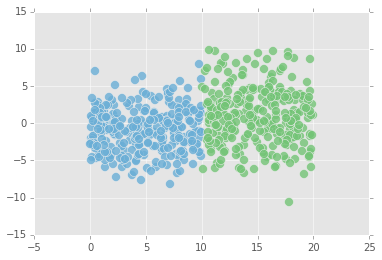

In [3]:
import matplotlib.pyplot as mpl
mpl.style.use('ggplot')
mpl.scatter(adata[0],adata[1], s=80, facecolors=mpl.cm.Blues(0.5,0.8))
mpl.scatter(bdata[0],bdata[1], s=80, facecolors=mpl.cm.Greens(0.5,0.8))

### Fit the Step

In [4]:
import stepfit

In [5]:
step = stepfit.step_fitter(np.concatenate([adata[0],bdata[0]]), 
                           np.concatenate([adata[1],bdata[1]]), 
                           np.concatenate([adata[2],bdata[2]]),
                          xCut = 10)

In [6]:
step.fit(sigma_a_guess=2,sigma_b_guess=2, mean_a_guess=-1.5,mean_b_guess=-0.8)

STARTS MINUIT FIT


FCN = 3114.79312505 
 TOTAL NCALL = 85 
 NCALLS = 85 
 
 
 EDM = 2.41214283749e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mean_a,-9.091042e-01,1.640327e-01,0.000000e+00,0.000000e+00,,,
2,sigma_a,2.017921e+00,1.633052e-01,0.000000e+00,0.000000e+00,,,
3,mean_b,1.019291e+00,2.138121e-01,0.000000e+00,0.000000e+00,,,
4,sigma_b,3.116837e+00,1.796356e-01,0.000000e+00,0.000000e+00,,,


The fitted values are in agreement with the input data.

# End